# SVR

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR

In [2]:
sys.path.insert(0, "../..")
import problem

## Load data

In [3]:
X_train, y_train = problem.get_train_data("../..")
X_test, y_test = problem.get_test_data("../..")

## Linear SVM with external data

In [6]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]
categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = LinearSVR(max_iter=10_000)

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f85d1ae0820>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f85d1ae03a0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f85d1ae0790>,
                                     kw_args={'dr...})),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('linearsvr', LinearSVR(max_iter=10000))])

In [7]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.81
Test set, RMSE=0.72


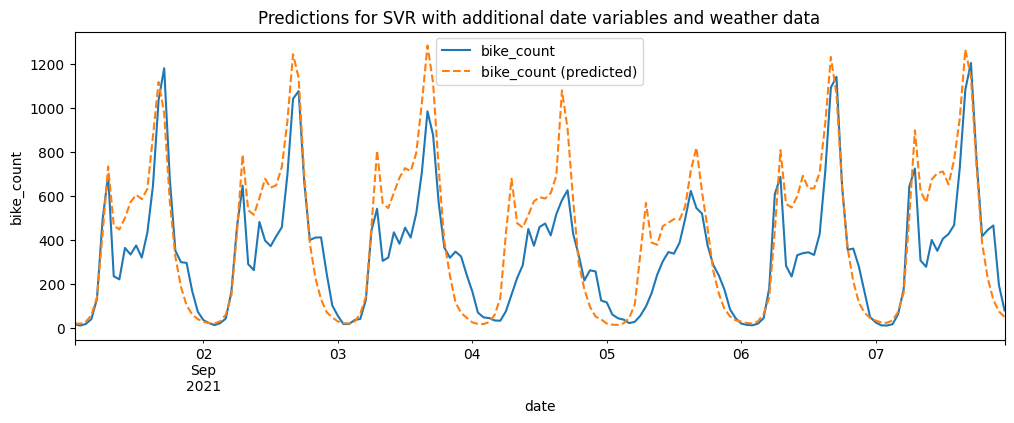

In [8]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "SVR with additional date variables and weather data",
)

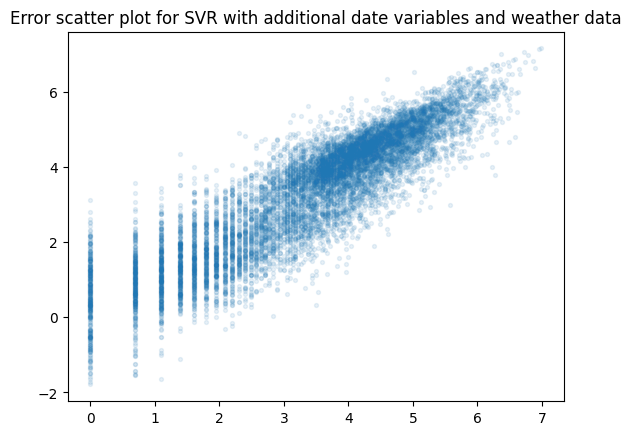

In [9]:
problem.error_plot(
    y_pred_test, y_test, "SVR with additional date variables and weather data"
)